# Peter na Mbwa Mwitu: Mazingira Halisi

Katika hali yetu, Peter aliweza kuzunguka karibu bila kuchoka au kuhisi njaa. Katika dunia halisi zaidi, anapaswa kukaa chini na kupumzika mara kwa mara, na pia kujilisha. Hebu tufanye dunia yetu iwe halisi zaidi kwa kutekeleza sheria zifuatazo:

1. Kwa kusafiri kutoka sehemu moja hadi nyingine, Peter hupoteza **nguvu** na kupata **uchovu**.
2. Peter anaweza kupata nguvu zaidi kwa kula matufaha.
3. Peter anaweza kuondoa uchovu kwa kupumzika chini ya mti au kwenye nyasi (yaani, kutembea hadi eneo lenye mti au nyasi - uwanja wa kijani).
4. Peter anahitaji kumtafuta na kumuua mbwa mwitu.
5. Ili kumuua mbwa mwitu, Peter anahitaji kuwa na viwango fulani vya nguvu na uchovu, vinginevyo atashindwa katika mapambano.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

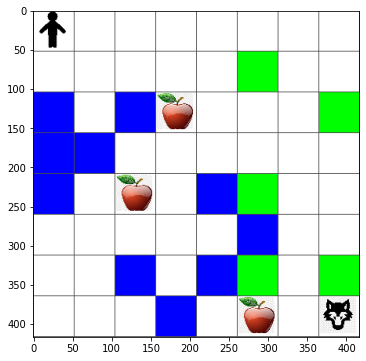

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Kufafanua hali

Katika sheria zetu mpya za mchezo, tunahitaji kufuatilia nishati na uchovu katika kila hali ya ubao. Kwa hivyo tutaunda kitu `state` ambacho kitabeba taarifa zote zinazohitajika kuhusu hali ya sasa ya tatizo, ikijumuisha hali ya ubao, viwango vya sasa vya nishati na uchovu, na kama tunaweza kumshinda mbwa mwitu tukiwa katika hali ya mwisho:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Kazi ya Malipo



In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algorithimu ya Q-Learning

Algorithimu halisi ya kujifunza haibadiliki sana, tunatumia tu `state` badala ya nafasi ya bodi pekee.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

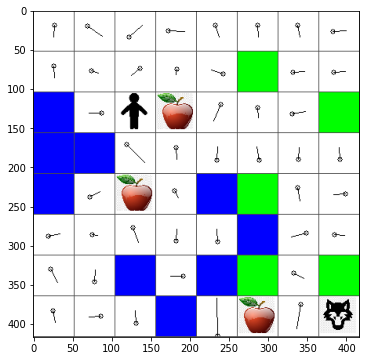

In [11]:
m.plot(Q)

## Matokeo

Tuweke kuona kama tulifanikiwa kumfundisha Peter kupambana na mbwa mwitu!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Sasa tunaona visa vichache sana vya kuzama, lakini Peter bado hawezi kila wakati kumuua mbwa mwitu. Jaribu kujaribu na uone kama unaweza kuboresha matokeo haya kwa kucheza na hyperparameters.


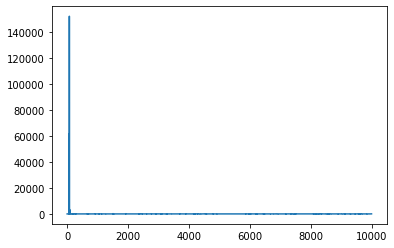

In [13]:
plt.plot(lpath)


---

**Kanusho**:  
Hati hii imetafsiriwa kwa kutumia huduma ya kutafsiri ya AI [Co-op Translator](https://github.com/Azure/co-op-translator). Ingawa tunajitahidi kuhakikisha usahihi, tafadhali fahamu kuwa tafsiri za kiotomatiki zinaweza kuwa na makosa au kutokuwa sahihi. Hati ya asili katika lugha yake ya awali inapaswa kuzingatiwa kama chanzo cha mamlaka. Kwa taarifa muhimu, tafsiri ya kitaalamu ya binadamu inapendekezwa. Hatutawajibika kwa kutoelewana au tafsiri zisizo sahihi zinazotokana na matumizi ya tafsiri hii.
